# 프로젝트: COUPON PURCHASE PREDICTION
## 팀 COUPANG 

# 목차
## 1. 프로젝트 개요
## 2. Preprocessing
## 3. EDA & feature selection
## 4. 모델링
##  5. 예측 및 제출

## 1. 프로젝트 개요
    1-1) 내용: 고객의 패턴(방문, 구매 내역 등)을 파악하여 해당 고객이 어떤 쿠폰을 구매할지(고객당 10개) 예측
    1-2) 홈페이지: https://ponpare.jp/
    1-3) 데이터 set: 아래 데이터 불러오기 참조
    1-4) 참가자수: 1076명
    1-5) 평가 기준: Mean Average Precision @ 10 (MAP@10)

![image.png](./image/image.png)

    1-6) 수단: cosine similarity
    1-7) 최종 성적: 0.006201, 76 / 1076 (상위 7%)

### IMPORT

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# from tqdm import tqdm
import numpy as np
import pandas as pd
import math
import datetime as dt
import matplotlib as mpl
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
mpl.use('Agg')
import seaborn as sns
import sklearn as sk
from sklearn.preprocessing import *
from scipy import spatial

In [3]:
# 테이블 현황 파악을 위한 함수 
def summary_table(table):
    df = pd.DataFrame()
    for i in table.columns:
        name = i
        dtype = table[i].dtype.name
        null = table[i].isnull().sum()
        act = table.shape[0] - null
        unique = len(table[i].unique())
        data = {'name': name, 'dtype': dtype, 'null': null, 'act': act, 'unique': unique}
        df = df.append(data, ignore_index=True)
    return df

### 데이터 불러오기: 일본어는 영어로 번역, 지역에 Prefecture가 붙은 지명은 Prefecture 제외

In [4]:
# base data
location = pd.read_csv('coupon_data_project2/prefecture_locations_translated_en.csv') # 지역 위치 정보(위도/경도): 47rows * 4columns 
user_list = pd.read_csv('coupon_data_project2/user_list_translated_en.csv', 
                        parse_dates=['WITHDRAW_DATE', 'REG_DATE']) # user 정보: 22,873 rows * 6columns

# train
detail_train = pd.read_csv('coupon_data_project2/coupon_detail_train_translated_en.csv', 
                           parse_dates=['I_DATE'])  # 쿠폰 구매 내역: 168,996rows * 6columns

visit_train = pd.read_csv('coupon_data_project2/coupon_visit_train.csv',
                          parse_dates=['I_DATE']) # 쿠폰 조회 내역: 2,833,180rows * 8 columns

area_train = pd.read_csv('coupon_data_project2/coupon_area_train_translated_en.csv') # 쿠폰 사용 가능 지역: 138,185rows * 3 columns

coupon_list_train = pd.read_csv('coupon_data_project2/coupon_list_train_translated_en.csv', 
                                parse_dates=['DISPFROM', 'DISPEND', 'VALIDFROM', 'VALIDEND']) # 쿠폰 리스트: 19,413rows * 24 columns


# test data
area_test = pd.read_csv('coupon_data_project2/coupon_area_test_translated_en.csv') # 쿠폰 사용 가능 지역: 2,165 rows * 3 columns
coupon_list_test = pd.read_csv('coupon_data_project2/coupon_list_test_translated_en.csv',
                               parse_dates=['DISPFROM', 'DISPEND', 'VALIDFROM', 'VALIDEND']) # 쿠폰 리스트: 310 rows * 24columns

# submisiion
submission = pd.read_csv('coupon_data_project2/sample_submission.csv') # 제출 자료: 22,873 rows * 2 columns

--------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------
## 2. Preprocessing
--------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------


### 2-1. detail_train : 쿠폰 구매 내역: 168,996rows * 6columns
--------------------------------------------------------------------------------------------------------
- I_DATE: 구매한 날짜
- ITEM_COUNT: 구매한 제품 갯수
- COUPON_ID_hash: COUPON number
- PURCHASEID_hash: 구매 번호
- SMALL_AREA_NAME: 고객 거주지역(소단위)
- USER_ID_hash: USER ID

In [4]:
summary_table(detail_train).pivot_table(index = ['dtype', 'name'])

act  null    unique
dtype          name                                     
datetime64[ns] I_DATE           168996.0   0.0  130309.0
int64          ITEM_COUNT       168996.0   0.0      32.0
object         COUPON_ID_hash   168996.0   0.0   19368.0
               PURCHASEID_hash  168996.0   0.0  168996.0
               SMALL_AREA_NAME  168996.0   0.0      55.0
               USER_ID_hash     168996.0   0.0   22782.0

#### 2-1-1) 신규 columns 생성

- merge 후 구매 구분을 위한 PURCHASE_FLG

In [5]:
detail_train['PURCHASE_FLG'] = 1

#### 2-1-2) column명 변경

- I_DATE -> purchase_date: merge 후 구매일자 구분을 위함

- SMALL_AREA_NAME: user_small로 변경 / coupon list의 지역(판매 spot)과 구분하기 위함

In [6]:
detail_train.rename(columns = {'I_DATE': 'purchase_date'}, inplace=True)
detail_train.rename(columns = {'SMALL_AREA_NAME': 'user_small'}, inplace=True)

### 2-2. visit_train: 쿠폰 조회 내역: 2,833,180rows * 8 columns
--------------------------------------------------------------------------------------------------------
- I_DATE: 홈페이지 방문 날짜
- PAGE_SERIAL: page number
- PURCHASE_FLG: 구매 여부(0: 구매 안함, 1: 구매)
- REFERRER_hash, SESSION_ID_hash: 접속 로그와 비슷한 개념
- USER_ID_hash: USER ID
- VIEW_COUPON_ID_hash: 고객이 조회한 COUPON ID

In [7]:
summary_table(visit_train).pivot_table(index = ['dtype', 'name'])

act       null     unique
dtype          name                                                
datetime64[ns] I_DATE               2833180.0        0.0  2638744.0
int64          PAGE_SERIAL          2833180.0        0.0      466.0
               PURCHASE_FLG         2833180.0        0.0        2.0
object         PURCHASEID_hash       122389.0  2710791.0   114775.0
               REFERRER_hash        2833180.0        0.0    97319.0
               SESSION_ID_hash      2833180.0        0.0  1046179.0
               USER_ID_hash         2833180.0        0.0    22805.0
               VIEW_COUPON_ID_hash  2833180.0        0.0    32628.0

#### 2-2-1) 신규 column 생성

In [8]:
visit_train['VIEW'] = 1

#### 2-2-2) column명 변경

In [9]:
visit_train.rename(columns = {'I_DATE': 'VIEW_DATE'}, inplace=True)
visit_train.rename(columns = {'VIEW_COUPON_ID_hash': 'COUPON_ID_hash'}, inplace=True)

### 2-3. Coupon_list, 쿠폰 리스트: 19,413rows * 24 columns
--------------------------------------------------------------------------------------------------------
- DISPFROM, DISPEND, DISPPERIOD: 상품 release 기간
- VALIDFROM, VALIDEND, VALIDPERIOD: 상품 유효 기간
- CATALOG_PRICE: 소비자가(정가)
- DISCOUNT_PRICE: 할인가격
- PRICE_RATE: 할인율
- USABLE_DATE_MON~FRI, HOLIDAY: 해당 요일 사용 가능 여부
- CAPSULE_TEXT: 상품 소분류
- GENRE_NAME: 상품 중분류
- LARGE_AREA_NAME: 쿠폰 사용 가능 지역(대분류)
- ken_name: 쿠폰 사용 가능 지역(중분류, Prefecture)
- SMALL_AREA_NAME: 쿠폰 사용 가능 지역(소분류)

In [10]:
summary_table(coupon_list_train).pivot_table(index = ['dtype', 'name'])

act    null   unique
dtype          name                                                
datetime64[ns] DISPEND                     19413.0     0.0    373.0
               DISPFROM                    19413.0     0.0    378.0
               VALIDEND                    13266.0  6147.0    515.0
               VALIDFROM                   13266.0  6147.0    377.0
float64        VALIDPERIOD                 13266.0  6147.0    181.0
int64          CATALOG_PRICE               19413.0     0.0   2415.0
               DISCOUNT_PRICE              19413.0     0.0   1115.0
               DISPPERIOD                  19413.0     0.0     18.0
               PRICE_RATE                  19413.0     0.0     71.0
               USABLE_DATE_BEFORE_HOLIDAY  19413.0     0.0      2.0
               USABLE_DATE_FRI             19413.0     0.0      2.0
               USABLE_DATE_HOLIDAY         19413.0     0.0      2.0
               USABLE_DATE_MON             19413.0     0.0      2.0
               USABLE_DATE_SAT             19413.0     0.0      2.0
               USABLE_DATE_SUN             19413.0     0.0      2.0
               USABLE_DATE_THU             19413.0     0.0      2.0
               USABLE_DATE_TUE             19413.0     0.0      2.0
               USABLE_DATE_WED             19413.0     0.0      2.0
object         CAPSULE_TEXT                19413.0     0.0     24.0
               COUPON_ID_hash              19413.0     0.0  19413.0
               GENRE_NAME                  19413.0     0.0     13.0
               LARGE_AREA_NAME             19413.0     0.0      9.0
               SMALL_AREA_NAME             19413.0     0.0     55.0
               ken_name                    19413.0     0.0     47.0

#### 2-3-1) 전처리 일관성을 유지를 위한 coupon_list merge(311~ train임)

In [11]:
coupon_list = pd.merge(coupon_list_test, coupon_list_train, how='outer')

In [12]:
coupon_list_test.shape, coupon_list_train.shape, coupon_list.shape

((310, 24), (19413, 24), (19723, 24))

#### 2-3-2) 신규 columns 생성

In [13]:
df = coupon_list.copy()
df['A'] = 1
df.pivot_table(index=['GENRE_NAME', 'CAPSULE_TEXT'], values = ['CATALOG_PRICE', "A"], aggfunc=[np.mean, np.sum])

mean                 sum  \
                                                  A CATALOG_PRICE     A   
GENRE_NAME               CAPSULE_TEXT                                     
Beauty                   Beauty                 1.0  10571.046512    43   
Delivery service         Delivery service       1.0   6452.507589  5930   
Food                     Food                   1.0   5336.447616  3713   
Gift card                Gift card              1.0   2401.666667   105   
Hair salon               Hair salon             1.0  13876.677618  1461   
Health and medical       Health and medical     1.0  34309.830508    59   
Hotel and Japanese hotel Guest house            1.0  21138.461538    13   
                         Hotel                  1.0  18575.574393  1976   
                         Japanese hotel         1.0  24232.636364  1375   
                         Japanse guest house    1.0  19599.595960    99   
                         Lodge                  1.0  14663.000000    25   
                         Public hotel           1.0  11394.444444     9   
                         Resort inn             1.0  17180.922330   103   
                         Vacation rental        1.0  16586.206897    29   
Leisure                  Leisure                1.0   3576.755556   675   
Lesson                   Class                  1.0  46011.111111    18   
                         Correspondence course  1.0  58880.000000    18   
                         Lesson                 1.0  50325.460624   673   
Nail and eye salon       Nail and eye salon     1.0  10415.516330   643   
Other coupon             Event                  1.0   2000.250000     4   
                         Other                  1.0   7468.938628   831   
                         Web service            1.0   2515.909091    44   
Relaxation               Relaxation             1.0   8608.674775  1110   
Spa                      Spa                    1.0  21994.594524   767   

                                                              
                                               CATALOG_PRICE  
GENRE_NAME               CAPSULE_TEXT                         
Beauty                   Beauty                       454555  
Delivery service         Delivery service           38263370  
Food                     Food                       19814230  
Gift card                Gift card                    252175  
Hair salon               Hair salon                 20273826  
Health and medical       Health and medical          2024280  
Hotel and Japanese hotel Guest house                  274800  
                         Hotel                      36705335  
                         Japanese hotel             33319875  
                         Japanse guest house         1940360  
                         Lodge                        366575  
                         Public hotel                 102550  
                         Resort inn                  1769635  
                         Vacation rental              481000  
Leisure                  Leisure                     2414310  
Lesson                   Class                        828200  
                         Correspondence course       1059840  
                         Lesson                     33869035  
Nail and eye salon       Nail and eye salon          6697177  
Other coupon             Event                          8001  
                         Other                       6206688  
                         Web service                  110700  
Relaxation               Relaxation                  9555629  
Spa                      Spa                        16869854

In [14]:
# 캡슐과 장르 통합 및 명칭 변경
coupon_list['Case'] = coupon_list['CAPSULE_TEXT'] + coupon_list['GENRE_NAME']
coupon_list['Case'] = coupon_list['Case'].apply(lambda x: "HOTEL" if x == 'Guest houseHotel and Japanese hotel' 
                          or x == 'HotelHotel and Japanese hotel'
                          or x == 'Japanese hotelHotel and Japanese hotel'
                          or x == 'Japanse guest houseHotel and Japanese hotel'
                          or x == 'LodgeHotel and Japanese hotel'
                          or x == 'Public hotelHotel and Japanese hotel'
                          or x == 'Resort innHotel and Japanese hotel'
                          or x == 'Vacation rentalHotel and Japanese hotel'
                          else "NAIL" if x == 'Nail and eye salonNail and eye salon'
                          else "HAIR" if x == 'Hair salonHair salon'
                          else "FOOD" if x == 'FoodFood'  # FOOD
                          else "SPA" if x == 'SpaSpa'  # SPA
                          else "BEUATY" if x == 'BeautyBeauty'  # BEUATY
                          else "CLASS" if x == 'ClassLesson' # CLASS
                          else "CORRESPONDENCE" if x == 'Correspondence courseLessonClassLesson'
                          else "DELIVERY" if x == 'Delivery serviceDelivery service'
                          else "EVENT" if x == 'EventOther coupon' # EVENT
                          else "GIFT" if x == 'Gift cardGift card'
                          else "HEALTH" if x == 'Health and medicalHealth and medical' #HEALTH
                          else "LEISURE" if x == 'LeisureLeisure'  # LEISURE
                          else "LESSON" if x == 'LessonLesson' # LESSON
                          else "OTHER" if x == 'OtherOther coupon'
                          else "RELAXATION" if x == 'RelaxationRelaxation'
                          else "WEB" if x == 'Web serviceOther coupon'  # WEB
                          else 'OTHER'
                          )

coupon_list = coupon_list.drop(labels = ['CAPSULE_TEXT', 'GENRE_NAME'], axis=1)

In [15]:
# 실판매가 계산
coupon_list['Price'] = coupon_list['CATALOG_PRICE'] + coupon_list['DISCOUNT_PRICE']

#### 2-3-3) column명 변경

In [16]:
# 지역명 변경
coupon_list.rename(columns = {"LARGE_AREA_NAME": "spot_large", 
                              "ken_name": "spot_pref", 
                              "SMALL_AREA_NAME": "spot_small"}, inplace=True)

#### 2-3-4) Null 값 및 오류 처리

In [17]:
# usable: nan -> 1, 2 -> 0
coupon_list['USABLE_DATE_MON'].replace([0,2,1,np.nan],[0,0,1,1], inplace=True)
coupon_list['USABLE_DATE_TUE'].replace([0,2,1,np.nan],[0,0,1,1], inplace=True)
coupon_list['USABLE_DATE_WED'].replace([0,2,1,np.nan],[0,0,1,1], inplace=True)
coupon_list['USABLE_DATE_THU'].replace([0,2,1,np.nan],[0,0,1,1], inplace=True)
coupon_list['USABLE_DATE_FRI'].replace([0,2,1,np.nan],[0,0,1,1], inplace=True)
coupon_list['USABLE_DATE_SAT'].replace([0,2,1,np.nan],[0,0,1,1], inplace=True)
coupon_list['USABLE_DATE_SUN'].replace([0,2,1,np.nan],[0,0,1,1], inplace=True)
coupon_list['USABLE_DATE_HOLIDAY'].replace([0,2,1,np.nan],[0,0,1,1], inplace=True)
coupon_list['USABLE_DATE_BEFORE_HOLIDAY'].replace([0,2,1,np.nan],[0,0,1,1], inplace=True)

#### 2-3-5) train & test set 분리

In [18]:
# train set과 test set을 다시 분리
coupon_list_train = coupon_list[311:]
coupon_list_test = coupon_list[:310]

### 2-4. User_list
--------------------------------------------------------------------------------------------------------
- REG_DATE: 가입한 날짜
- WITHDRAW_DATE: 탈퇴한 날짜
- AGE: 연령
- PREF_NAME: 거주 지역
- SEX_ID: 성별
- USER_ID_hash: USER ID

In [19]:
summary_table(user_list).pivot_table(index = ['dtype', 'name'])

act     null   unique
dtype          name                                    
datetime64[ns] REG_DATE       22873.0      0.0  21924.0
               WITHDRAW_DATE    922.0  21951.0    904.0
int64          AGE            22873.0      0.0     66.0
object         PREF_NAME      15617.0   7256.0     48.0
               SEX_ID         22873.0      0.0      2.0
               USER_ID_hash   22873.0      0.0  22873.0

#### 2-4-1) column명 변경

In [20]:
user_list.rename(columns = {'PREF_NAME': 'user_pref'}, inplace=True)

#### 2-4-2) SEX_ID 0,1 로 변경(f: 0, m: 1)

In [21]:
# SEX_ID: f는 0으로 M은 1로
user_list['SEX_ID'] = user_list['SEX_ID'].apply(lambda x: 0 if x == 'f' else 1) 

### 2-5. train set 구성
--------------------------------------------------------------------------------------------------------

#### 2-5-1) visit_train & detail_train -> train

In [22]:
train= pd.merge(visit_train, detail_train, how='outer')

In [23]:
train.shape

(2887402, 12)

#### 2-5-2) train & coupon_list

In [24]:
train = pd.merge(train, coupon_list, how='left', on='COUPON_ID_hash')

In [25]:
train.shape 

(2887402, 35)

#### 2-5-3) train & user_list

In [26]:
train = pd.merge(train, user_list, how='left', on='USER_ID_hash')

In [27]:
train.shape

(2887402, 40)

## 3. EDA & Feature selection

### 3-1. 데이터 분포

In [28]:
summary_table(train).pivot_table(index = ['dtype', 'name'])

act       null     unique
dtype          name                                                       
datetime64[ns] DISPEND                     2572169.0   315233.0      376.0
               DISPFROM                    2572169.0   315233.0      381.0
               REG_DATE                    2887402.0        0.0    21895.0
               VALIDEND                    1779839.0  1107563.0      516.0
               VALIDFROM                   1779839.0  1107563.0      378.0
               VIEW_DATE                   2833180.0    54222.0  2638745.0
               WITHDRAW_DATE                 19369.0  2868033.0      904.0
               purchase_date                176611.0  2710791.0   130310.0
float64        CATALOG_PRICE               2572169.0   315233.0     2417.0
               DISCOUNT_PRICE              2572169.0   315233.0     1116.0
               DISPPERIOD                  2572169.0   315233.0       19.0
               ITEM_COUNT                   176611.0  2710791.0       33.0
               PAGE_SERIAL                 2833180.0    54222.0      467.0
               PRICE_RATE                  2572169.0   315233.0       72.0
               Price                       2572169.0   315233.0     4087.0
               USABLE_DATE_BEFORE_HOLIDAY  2572169.0   315233.0        3.0
               USABLE_DATE_FRI             2572169.0   315233.0        3.0
               USABLE_DATE_HOLIDAY         2572169.0   315233.0        3.0
               USABLE_DATE_MON             2572169.0   315233.0        3.0
               USABLE_DATE_SAT             2572169.0   315233.0        3.0
               USABLE_DATE_SUN             2572169.0   315233.0        3.0
               USABLE_DATE_THU             2572169.0   315233.0        3.0
               USABLE_DATE_TUE             2572169.0   315233.0        3.0
               USABLE_DATE_WED             2572169.0   315233.0        3.0
               VALIDPERIOD                 1779839.0  1107563.0      181.0
               VIEW                        2833180.0    54222.0        2.0
int64          AGE                         2887402.0        0.0       66.0
               PURCHASE_FLG                2887402.0        0.0        2.0
               SEX_ID                      2887402.0        0.0        2.0
object         COUPON_ID_hash              2887402.0        0.0    32629.0
               Case                        2572169.0   315233.0       17.0
               PURCHASEID_hash              176611.0  2710791.0   168997.0
               REFERRER_hash               2833180.0    54222.0    97320.0
               SESSION_ID_hash             2833180.0    54222.0  1046180.0
               USER_ID_hash                2887402.0        0.0    22833.0
               spot_large                  2572169.0   315233.0       10.0
               spot_pref                   2572169.0   315233.0       48.0
               spot_small                  2572169.0   315233.0       56.0
               user_pref                   2334838.0   552564.0       48.0
               user_small                   176611.0  2710791.0       56.0

#### 3-1-1) train set 요약: 2,913,043 행과 42개 columns로 구성 -> null 값처리 

##### 기초 정보 & 구매정보로부터 확보한 데이터 
    a) 기초정보(test & train coupon_list)에 속하지 않는 315,233 개의 열: 제거(DISPFROM 기준 notnull 적용)
    b) VALIDPERIOD: 유효기간이 null이라는 건 구매에 제한이 없다는 것을 의미하므로 최대값으로 처리
    c) VALIDEND, VALIDFROM: 유효기간의 시작과 끝은 의미가 없음, drop 처리
------------------------------------------------------------------------------------------------    

#### 방문 & 구매정보로부터 확보한 데이터 -> test set에 적용이 어려움 or 프로젝트 목적에 필요 없는 데이터들
    d) REFERRER_hash, SESSION_ID_hash: 접속 log 값이므로 drop 처리
    e) PURCHASEID_hash: PURCHASE_FLG 기준으로 집계가 가능하므로 drop 처리
    f) user_small, user_pref: 유저정보가 없는 것이므로 NN처리
    g) VIEW: 관심도라고 볼 수 있지만, test set에 적용 불가
             null은 조회를 하지 않고 구매를 했다는 것을 의미하므로 0으로 처리
    h) VIEW_DATE, WITHDRAW_DATE: test set에 적용할 수 없는 특징으로, drop 처리
    i) ITEM_COUNT: detail 에만 존재하므로 310개의 새로운 쿠폰에는 적용 불가능
                   null은 0처리
    j) PAGE_SERIAL: test set 에 적용이 불가능하므로 drop 처리

In [29]:
# a) 기초정보(test & train coupon_list)에 속하지 않는 315,233 개의 열: 제거(DISPFROM 기준 notnull 적용)
train = train[train['DISPFROM'].notnull()]

In [30]:
# b) VALIDPERIOD: 유효기간이 null이라는 건 구매에 제한이 없다는 것을 의미하므로 최대값(179)으로 처리
train['VALIDPERIOD'] = train['VALIDPERIOD'].fillna(179)

In [31]:
# c) VALIDEND, VALIDFROM: 유효기간의 시작과 끝은 의미가 없음, drop 처리
train = train.drop(labels = ['VALIDEND', 'VALIDFROM'], axis=1)

In [32]:
# d) REFERRER_hash, SESSION_ID_hash: 접속 log 값이므로 drop 처리
train = train.drop(labels = ['REFERRER_hash', 'SESSION_ID_hash'], axis=1)

In [33]:
# e) PURCHASEID_hash: PURCHASE_FLG 기준으로 집계가 가능하므로 drop 처리
train = train.drop(labels = ['PURCHASEID_hash'], axis=1)

In [34]:
# f) user_small, user_pref: 유저정보가 없는 것이므로 NN처리 -> detail에만 있던 정보이기 때문에 test set에 적용할 수 없음
train['user_small'] = train['user_small'].fillna('NN')
train['user_pref'] = train['user_pref'].fillna('NN')

In [35]:
# g) VIEW: null은 조회를 하지 않고 구매를 했다는 것을 의미하므로 0으로 처리 - visit에만 있던 정보이기 때문에 test set에 적용 할 수 없음
train['VIEW'] = train['VIEW'].fillna(0)

In [36]:
# h) VIEW_DATE, WITHDRAW_DATE: test set에 적용할 수 없는 특징으로, drop 처리
train = train.drop(labels = ['VIEW_DATE', 'WITHDRAW_DATE'], axis=1)

In [37]:
# i) ITEM_COUNT: 0처리
train = train.drop(labels = ['ITEM_COUNT'], axis=1)

In [38]:
# j) PAGE_SERIAL: test set 에 적용이 불가능하므로 drop 처리
train = train.drop(labels = ['PAGE_SERIAL'], axis=1)

#### 3-1-2) 분석대상 요약(purchase data)

- 전체 2,572,169 개 중 176,611(6.4%) 개의 구매 여부를 통해 예상 구매 쿠폰을 분석

구매 합계: 176611
전체: 2572169


([<matplotlib.patches.Wedge at 0x11d5b3e80>,
 [Text(0.523776,0.967295,'buy'), Text(-0.523776,-0.967295,'no')],
 [Text(0.285696,0.527615,'6.4%'), Text(-0.285696,-0.527615,'93.6%')])

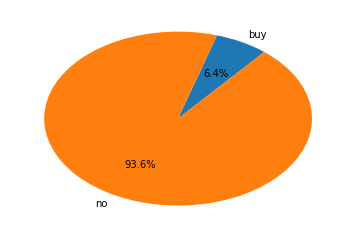

In [39]:
print('구매 합계: {}'.format(train.PURCHASE_FLG.sum(), ','))
print('전체: {}'.format(len(train.PURCHASE_FLG)))
plt.pie([train.PURCHASE_FLG.sum(), len(train.PURCHASE_FLG)], labels=["buy", "no"],
        autopct='%1.1f%%', 
        startangle=50)

### 3-2. numeric values
    3-2-1) PRICE_RATE: 50% 수준이 대다수 분포
    3-2-2) CATALOG_PRICE / DISCOUNT_PRICE / Price는 분포 및 상관관계가 유사 -> Price 유지하며, 정규화 처리
    3-2-3) DISPPERIOD: 기간이 긴 것들이 일부 존재(평균을 10이라고 했을때, 4만(구매는 9,300)) 하지만 OUTLIER라고 활 명확한 근거가 없음 
    3-2-4) VALIDPERIOD: 유효기간의 제한이 없는 것들이 대다수를 차지함

In [40]:
df = train.copy()

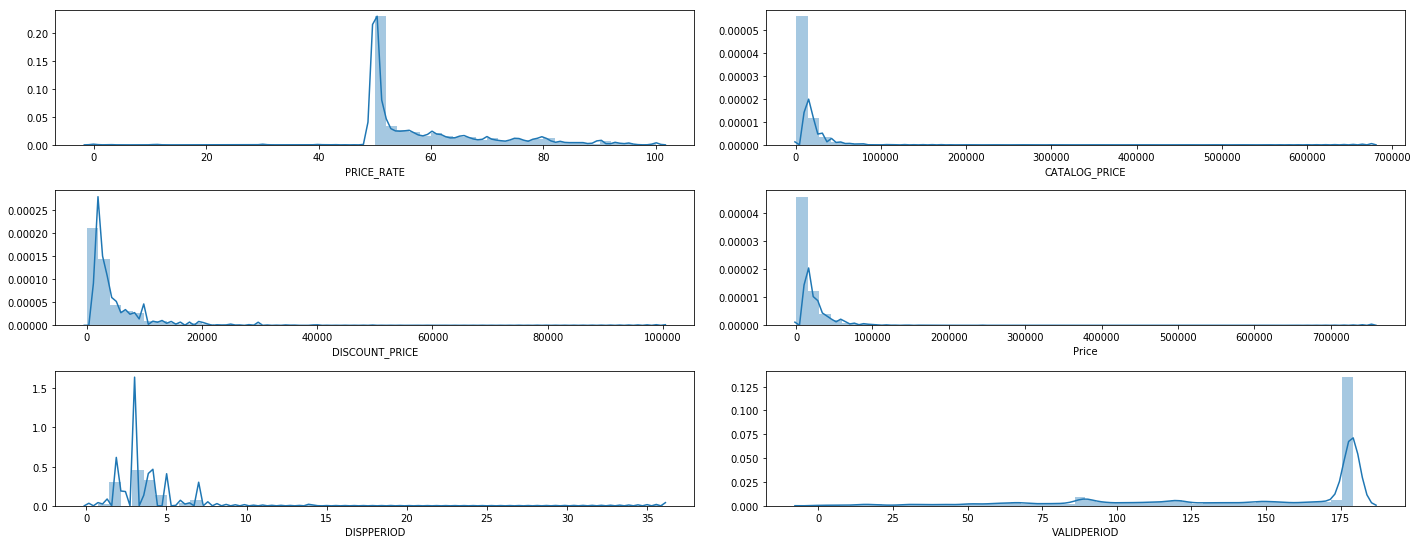

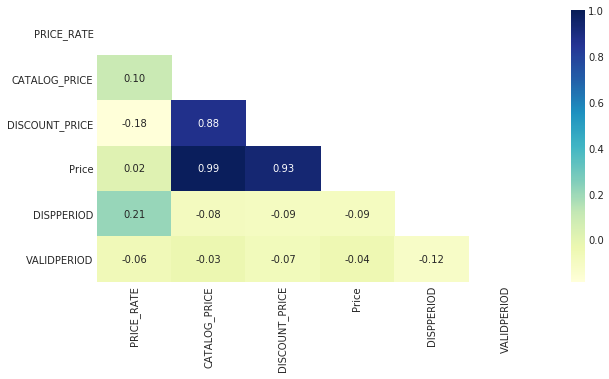

In [41]:
cols = ['PRICE_RATE', 'CATALOG_PRICE', 'DISCOUNT_PRICE', 'Price', 'DISPPERIOD', 'VALIDPERIOD']
plt.figure(figsize=(20, 10))
for idx, col in enumerate(cols):
    plt.subplot(4, 2, idx+1)
    sns.distplot(df[col])
plt.tight_layout(pad=2, h_pad=1)
plt.show()
corr = df.filter(cols).corr()
plt.figure(figsize = (10,5))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask = mask, annot=True, fmt = ".2f", cmap = "YlGnBu")

In [42]:
# PRICE 정규화
coupon_list["lnDPRICE"] = np.log1p(coupon_list["Price"])
coupon_list["mDPRICE"] = coupon_list.groupby("Case")["lnDPRICE"].transform(np.mean)
coupon_list["sDPRICE"] = coupon_list.groupby("Case")["lnDPRICE"].transform(np.std)
coupon_list["zprice"] = (coupon_list["lnDPRICE"] - coupon_list["mDPRICE"]) / coupon_list["sDPRICE"]

coupon_list = coupon_list.drop(labels = ['CATALOG_PRICE', 'DISCOUNT_PRICE', 'Price'], axis=1)
coupon_list = coupon_list.drop(labels = ['lnDPRICE', 'mDPRICE', 'sDPRICE'], axis=1)

### 3-3. cat values: CAPSULE , REGION(spot_large, spot_pref, spot_small), USABLE, SEX_ID, AGE)

In [43]:
CAPSULE = ['Case']
REGION = ['spot_large', 'spot_pref', 'splot_small']
etc = ['SEX_ID', 'AGE']

In [44]:
df = train.copy()

#### 3-3-1) PURCHASE_FLG를 y 값으로 분포 파악
- Case: DELIVERY, FOOD가 대다수를 차지 -> 연령 및 성별 등과 복합적으로 봐야할 것으로 보임
- REGION: 9개의 large_area에서 55개의 small area로 나뉨, 대다수가 Tokyo, Osaka등 대도시임

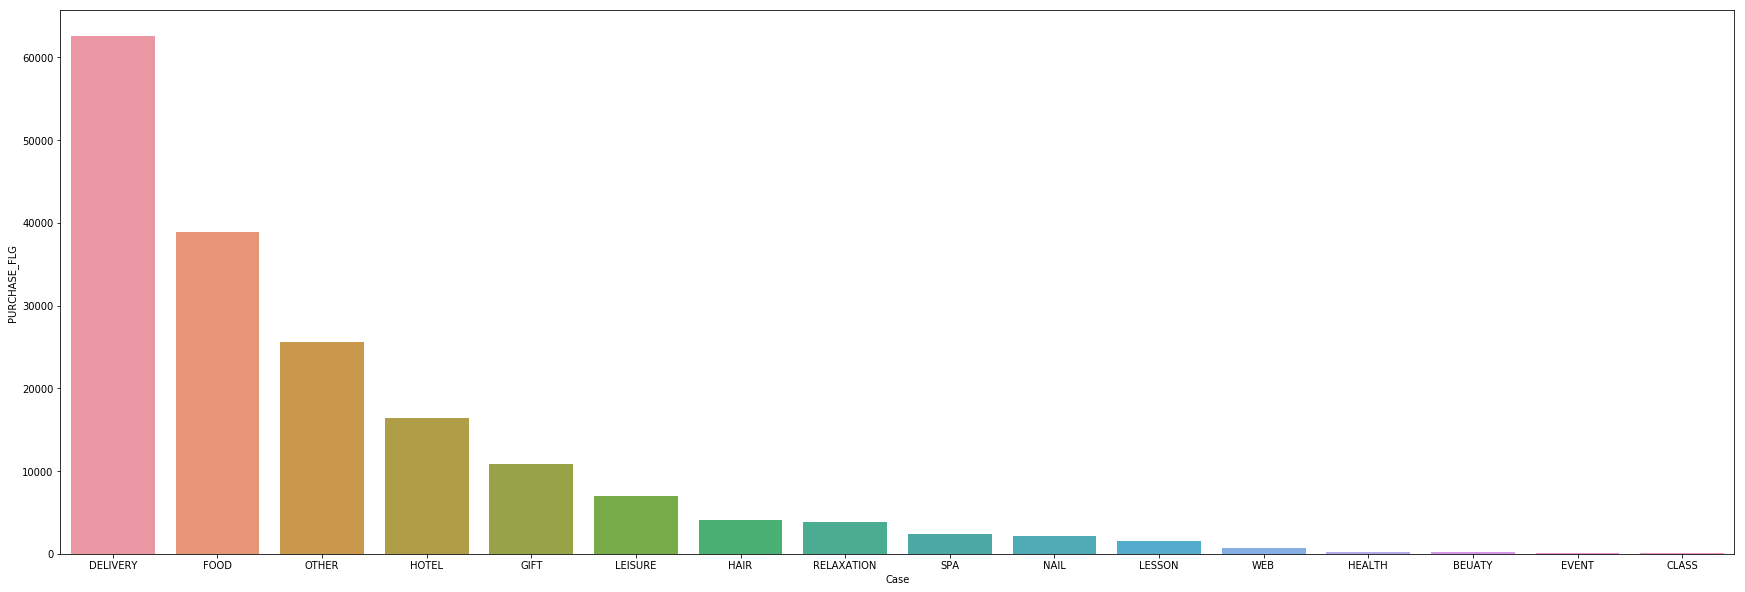

In [45]:
df = df.pivot_table(index = ['Case'], values = ['PURCHASE_FLG'], aggfunc=sum).reset_index()
df = df.sort_values(by='PURCHASE_FLG', ascending=False)
plt.figure(figsize = (30, 10))
sns.barplot(x='Case', y='PURCHASE_FLG', data=df)

#### 3-3-2) REGION
- Kanto(large) 지방중에서도 Tokyo가 대다수를 차지

In [46]:
df = train.copy()
print('spot_large : {}개'. format(len(df.spot_large.unique())))
print('spot_pref : {}개'. format(len(df.spot_pref.unique())))
print('spot_small : {}개'. format(len(df.spot_small.unique())))

spot_large : 9개
spot_pref : 47개
spot_small : 55개


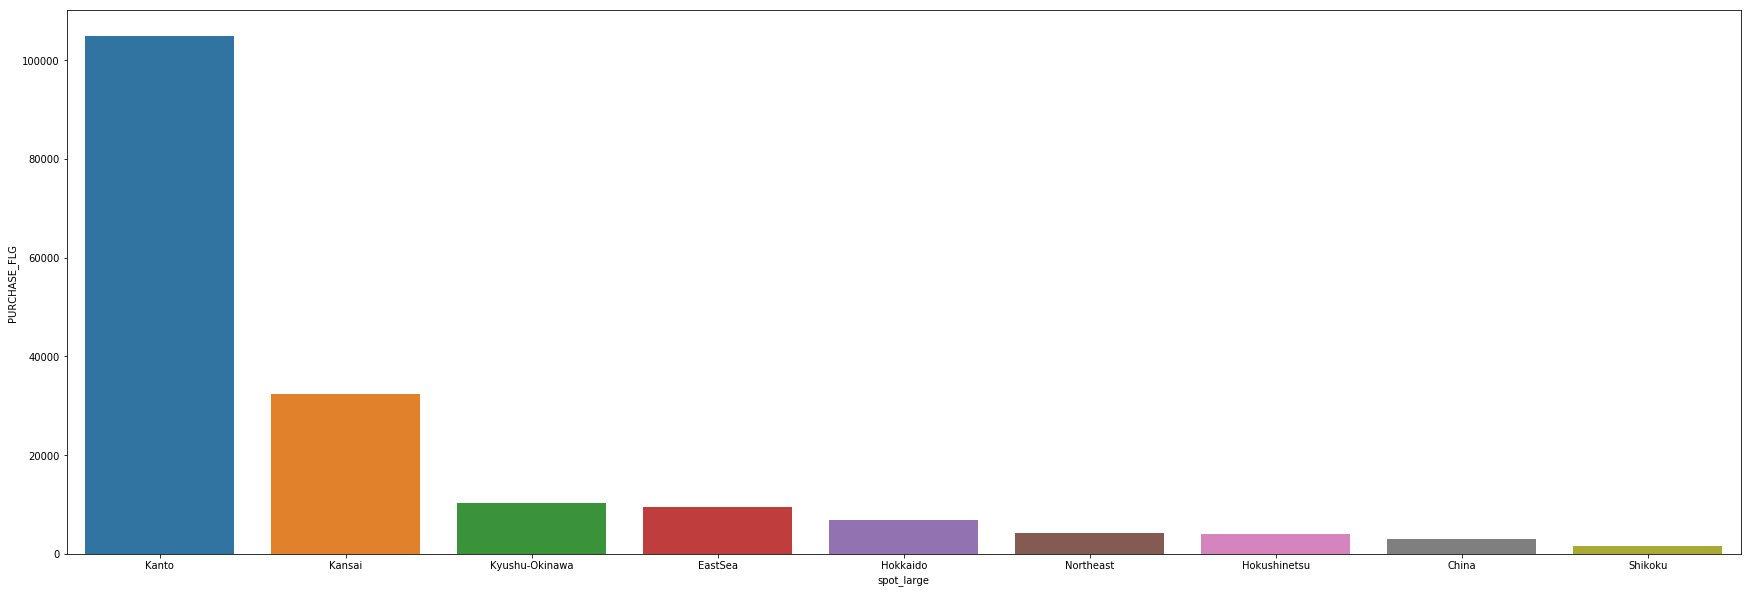

In [47]:
df = train.copy()
df = df.pivot_table(index = ['spot_large'], values = ['PURCHASE_FLG'], aggfunc=sum).reset_index()
df = df.sort_values(by='PURCHASE_FLG', ascending=False)
plt.figure(figsize = (30, 10))
sns.barplot(x='spot_large', y='PURCHASE_FLG', data=df)

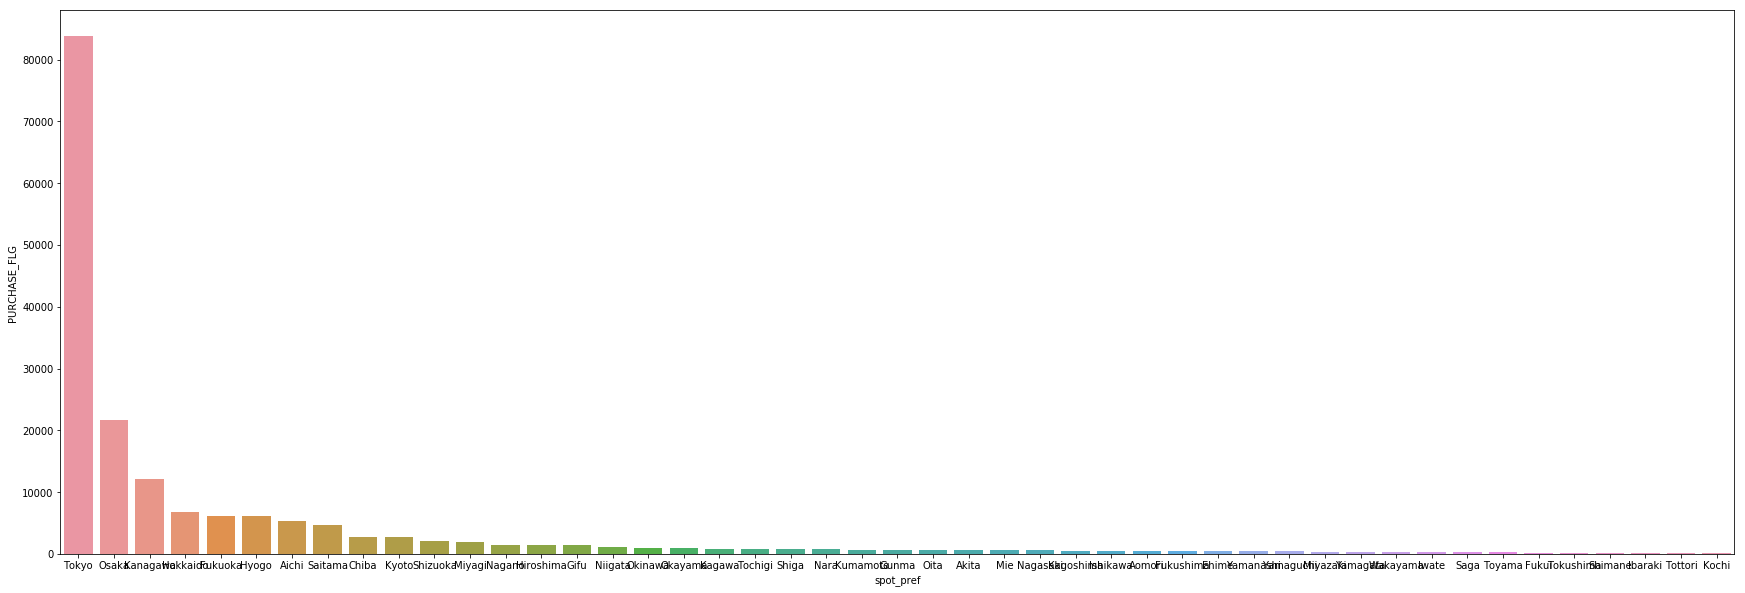

In [48]:
df = train.copy()
df = df.pivot_table(index = ['spot_pref'], values = ['PURCHASE_FLG'], aggfunc=sum).reset_index()
df = df.sort_values(by='PURCHASE_FLG', ascending=False)
plt.figure(figsize = (30, 10))
sns.barplot(x='spot_pref', y='PURCHASE_FLG', data=df)

#### 3-3-3) Case, REGION 등을 복합적으로 파악(POWER BI 활용)

https://app.powerbi.com/groups/me/reports/03d844da-8e2c-4a5f-8f48-58e71339b111/ReportSection73c0d48d6b7954dea7bc

- 30대~50대가 대부분의 소비를 차지하고 있으며, 이들이 delivery와 food를 주로 구매하고 있음
- 전체로 봤을 때는 여성의 소비 비중이 높음
- 여성과 남성의 구입 품목에서도 차이를 보이는데, 여성의 경우 delivery / 남성의 경우 Food 소비가 주를 이룸

![image.png](./image/image2.png)

- HOTLE과 LEISURE는 도쿄 중심이 아니라 다양한 지역으로 분포 되어 있음, 여행목적이기 때문인 것으로 보임
- 남성의 비중이 크고, 연령대도 높음
![image.png](./image/image3.png)

#### 지역과 Case는 여러가지 의미를 지니는 중요한 변수로 보여짐

### 3-4. usable_date

In [49]:
df = train.copy()
# 구매가 있는 것들만 필터링
df = df[df['purchase_date'].notnull()]
# 구매 요일 추가
df['weekday'] = df[['purchase_date']].apply(lambda x: dt.datetime.strftime(x['purchase_date'], '%a'), axis=1)

In [50]:
df_mon = df[df['USABLE_DATE_MON'] == 1]
df_mon = df_mon.groupby(['weekday'])['PURCHASE_FLG'].sum().reset_index()

df_Tue = df[df['USABLE_DATE_TUE'] == 1]
df_Tue = df_Tue.groupby(['weekday'])['PURCHASE_FLG'].sum().reset_index()

df_Wed = df[df['USABLE_DATE_WED'] == 1]
df_Wed = df_mon.groupby(['weekday'])['PURCHASE_FLG'].sum().reset_index()

df_Thu = df[df['USABLE_DATE_THU'] == 1]
df_Thu = df_Thu.groupby(['weekday'])['PURCHASE_FLG'].sum().reset_index()

df_Fri = df[df['USABLE_DATE_FRI'] == 1]
df_Fri = df_Fri.groupby(['weekday'])['PURCHASE_FLG'].sum().reset_index()

df_Sat = df[df['USABLE_DATE_SAT'] == 1]
df_Sat = df_Sat.groupby(['weekday'])['PURCHASE_FLG'].sum().reset_index()

df_Sun = df[df['USABLE_DATE_SUN'] == 1]
df_Sun = df_Sun.groupby(['weekday'])['PURCHASE_FLG'].sum().reset_index()

In [51]:
ls = [df_mon, df_Tue, df_Wed, df_Thu, df_Fri, df_Sat, df_Sun]
title = ['df_mon', 'df_Tue', 'df_Wed', 'df_Thu', 'df_Fri', 'df_sat', 'df_Sun']

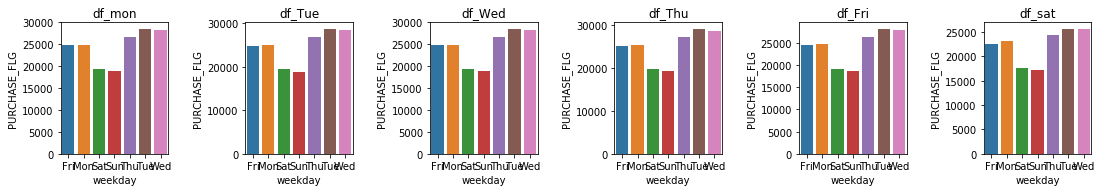

In [52]:

plt.figure(figsize=(20, 5))
for idx, col, title in zip(np.arange(1,7), ls, title):
    plt.subplot(2, 8, idx + 1)
    sns.barplot(x = col.weekday, y= col.PURCHASE_FLG)
    plt.title(title)
plt.tight_layout(pad=2, h_pad=1)
plt.show()

#### 해당 요일에만 사용가능한 쿠폰이 해당요일에 많이 팔렸을 것 같지만, 그렇지 않음

- 사용 가능 요일을 나타내는 USABLE feature는 의미가 없음
- 하지만 총 USABLE DAY에 따라 판매량을 재 검토해 볼 필요는 있음

In [53]:
df['usable'] = df['USABLE_DATE_MON'] + df['USABLE_DATE_TUE'] + df['USABLE_DATE_WED'] + df['USABLE_DATE_THU'] \
            + df['USABLE_DATE_FRI'] + df['USABLE_DATE_SAT'] + df['USABLE_DATE_SUN'] + df['USABLE_DATE_HOLIDAY'] \
                + df['USABLE_DATE_BEFORE_HOLIDAY']

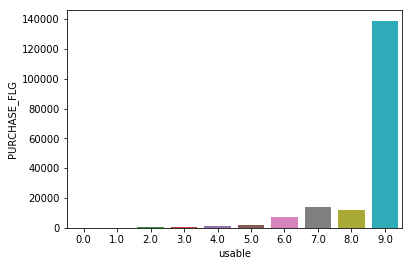

In [54]:
df_usable = df.groupby(['usable'])['PURCHASE_FLG'].sum().reset_index()
sns.barplot(x='usable', y='PURCHASE_FLG', data=df_usable)

![image.png](./image/image4.png)

- USABLE DAY가 많을 수록 판매량이 높음, DELIVERY는 모든 쿠폰의 USABLE DAY가 9였음
- 특정 요일에 특정 제품이 팔리는 경우는 없는듯, 전체적으로 비슷하며 3(화)~5(목) 요일의 판매량이 다소 높음
- 9개의 USABEL_DATE_() 를 모두 제거하고 USABLE 컬럼을 생성

In [55]:
df_usable = df.groupby(['usable', 'Case'])['PURCHASE_FLG','VIEW'].sum().reset_index()

In [56]:
# coupon_list
coupon_list['usable'] = coupon_list['USABLE_DATE_MON'] + coupon_list['USABLE_DATE_TUE'] + coupon_list['USABLE_DATE_WED'] + coupon_list['USABLE_DATE_THU'] \
            + coupon_list['USABLE_DATE_FRI'] + coupon_list['USABLE_DATE_SAT'] + coupon_list['USABLE_DATE_SUN'] + coupon_list['USABLE_DATE_HOLIDAY'] \
                + coupon_list['USABLE_DATE_BEFORE_HOLIDAY']

In [57]:
coupon_list.drop(labels = ['USABLE_DATE_MON', 'USABLE_DATE_TUE', 'USABLE_DATE_WED','USABLE_DATE_THU', 
                    'USABLE_DATE_FRI', 'USABLE_DATE_SAT', 'USABLE_DATE_SUN'], axis = 1, inplace=True)

### 3-5. Feature 확정
#### 선택 변수
- PRICE_RATE
- zprice
- usable
- Case - dummy
- spot_large - dummy
- spot_pref - dummy
- spot_small - dummy
- DISPPERIOD
- VALIDPERIOD

#### 제외 변수
- 구매 정보: ITEM_COUNT
- USER 정보: VIEW, user_small, user_pref, REG_DATE, SEX_ID, AGE, WITHDRAW_DATE
- coupon 정보: DSIPFROM, DISPEND, VALIDEND, VALIDFROM

In [58]:
train.columns

Index(['PURCHASE_FLG', 'COUPON_ID_hash', 'USER_ID_hash', 'VIEW',
       'purchase_date', 'user_small', 'PRICE_RATE', 'CATALOG_PRICE',
       'DISCOUNT_PRICE', 'DISPFROM', 'DISPEND', 'DISPPERIOD', 'VALIDPERIOD',
       'USABLE_DATE_MON', 'USABLE_DATE_TUE', 'USABLE_DATE_WED',
       'USABLE_DATE_THU', 'USABLE_DATE_FRI', 'USABLE_DATE_SAT',
       'USABLE_DATE_SUN', 'USABLE_DATE_HOLIDAY', 'USABLE_DATE_BEFORE_HOLIDAY',
       'spot_large', 'spot_pref', 'spot_small', 'Case', 'Price', 'REG_DATE',
       'SEX_ID', 'AGE', 'user_pref'],
      dtype='object')

In [59]:
ls_dummy = ['Case', 'spot_pref', 'spot_large', 'spot_small']

In [60]:
coupon_list = pd.get_dummies(coupon_list, columns = ls_dummy)
coupon_list_test = coupon_list[:310]

In [61]:
detail_train = detail_train.filter(['USER_ID_hash', 'COUPON_ID_hash'])
detail_train = pd.merge(detail_train, coupon_list, how='left', on='COUPON_ID_hash')
detail_train = detail_train.merge(user_list, on = 'USER_ID_hash', how = 'outer')

In [62]:
del_ls = ['DISPFROM', 'DISPEND', 'VALIDEND', 'REG_DATE', 'SEX_ID', 'AGE', 'WITHDRAW_DATE', 'user_pref',
          'VALIDFROM']
train_cos = detail_train.drop(del_ls, 1)

In [63]:
train_cos.shape

(169087, 136)

--------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------
## 4. 모델링
--------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------

## 4-1. 코사인 유사도 사용
: 아래 모델보다 나은 결과를 보임

### 4-1-1. 데이터 생성

In [64]:
test_cos = coupon_list_test.filter(train_cos.columns)
# test = test.drop(labels = ['spot_large', 'spot_small'] ,axis=1)
train['usable'] = train['USABLE_DATE_MON'] + train['USABLE_DATE_TUE'] + train['USABLE_DATE_WED'] + train['USABLE_DATE_THU'] \
            + train['USABLE_DATE_FRI'] + train['USABLE_DATE_SAT'] + train['USABLE_DATE_SUN'] + train['USABLE_DATE_HOLIDAY'] \
                + train['USABLE_DATE_BEFORE_HOLIDAY']

In [65]:
compare_not_test = [i for i in train_cos.columns if i not in test_cos.columns]
compare_not_train = [i for i in test_cos.columns if i not in train_cos.columns]
print('only_train: {}  \n'.format(compare_not_test))
print('only_test: {}'.format(compare_not_train))

only_train: ['USER_ID_hash']  

only_test: []


### 4-1-2. 유사도 구하기

In [66]:
train_drop_c = train_cos.drop('COUPON_ID_hash', axis=1)
dfdf = train_drop_c.groupby(by='USER_ID_hash').apply(np.mean)

In [70]:
test_df = test_cos.drop('COUPON_ID_hash', axis=1)
test_df.columns

Index(['PRICE_RATE', 'DISPPERIOD', 'VALIDPERIOD', 'USABLE_DATE_HOLIDAY',
       'USABLE_DATE_BEFORE_HOLIDAY', 'zprice', 'usable', 'Case_BEUATY',
       'Case_CLASS', 'Case_DELIVERY',
       ...
       'spot_small_Tochigi', 'spot_small_Tokushima', 'spot_small_Tottori',
       'spot_small_Toyama', 'spot_small_Triple', 'spot_small_Wakayama',
       'spot_small_Yamagata', 'spot_small_Yamaguchi', 'spot_small_Yamanashi',
       'spot_small_Yokohama'],
      dtype='object', length=134)

In [71]:
dfdf = dfdf.fillna(0)

In [72]:
test_df = test_df.fillna(179)

In [74]:
vec1 = dfdf.copy()
vec2 = test_df.copy()

vec1 = scale(vec1)
vec1 = pd.DataFrame(data = vec1, index = dfdf.index, columns = dfdf.columns )

vec2 = scale(vec2)
vec2 = pd.DataFrame(data = vec2, index = test_df.index, columns = test_df.columns )

In [76]:
from numpy import dot
from numpy.linalg import norm

def cos_sim(vec1, vec2):
    return (dot(vec1, vec2)/(norm(vec1)*norm(vec2)))

In [78]:
matrix = []
for idx1 in tqdm(range(len(dfdf))):
    
    row = []
    for idx2 in range(len(test_features)):
        row.append(cos_sim(vec1.iloc[idx1], vec2.iloc[idx2]))
    matrix.append(row)

100%|██████████| 22873/22873 [23:58<00:00, 15.90it/s]


## 4-2. xgboost 사용

### 4-2-1. 데이터 스케일링

In [117]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scale = scaler.transform(X_train)
X_train_scale = pd.DataFrame(X_train_scale, columns=X_train.columns)
y_train = train.PURCHASE_FLG

### 4-2-2. 데이터 오버샘플링

In [123]:
from imblearn.over_sampling import *

X1, y1 = SMOTE(random_state=0).fit_sample(X_train_scale,y_train)
X1 = pd.DataFrame(X1, columns=X_train_scale.columns)
X1.columns

Index(['PRICE_RATE', 'DISPPERIOD', 'USABLE_DATE_MON', 'USABLE_DATE_TUE',
       'USABLE_DATE_WED', 'USABLE_DATE_THU', 'USABLE_DATE_FRI',
       'USABLE_DATE_SAT', 'USABLE_DATE_SUN', 'USABLE_DATE_HOLIDAY',
       'USABLE_DATE_BEFORE_HOLIDAY', 'zprice', 'SEX_ID', 'AGE', 'VALID',
       'Case_BEAUTY', 'Case_CLASS', 'Case_DELIVERY', 'Case_EVENT', 'Case_FOOD',
       'Case_GIFT', 'Case_HAIR', 'Case_HEALTH', 'Case_HOTEL', 'Case_LEISURE',
       'Case_LESSON', 'Case_NAIL', 'Case_OTHER', 'Case_RELAXATION', 'Case_SPA',
       'Case_WEB'],
      dtype='object')

### 4-2-3. xgboost로 모델링

In [125]:
model_xgb = xgboost.XGBClassifier(n_estimators=300, max_depth=4,
                                 objective = 'reg:logistic',
                                 subsample= 0.85,
                                 colsample_bytree=0.8,
                                 random_state=12345,
                                 min_child_weight=1,
                                 learning_rate=0.05)
model_xgb = model_xgb.fit(X1, y1)

In [128]:
y_pred = model_xgb.predict(X_train_scale)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

[[1839042  556516]
 [  70910  131342]]
             precision    recall  f1-score   support

          0       0.96      0.77      0.85   2395558
          1       0.19      0.65      0.30    202252

avg / total       0.90      0.76      0.81   2597810



## 5. 예측 및 제출
: 최종 제출은 코사인 유사도를 사용한 예측 결과 사용

In [79]:
coupons_ids = test_cos['COUPON_ID_hash']
result_index = vec1.index
result_columns = [coupons_ids[i] for i in range(0, 310)]
result_df = pd.DataFrame(index= result_index, columns=result_columns,data=matrix)

In [80]:
submission = pd.DataFrame(columns=['USER_ID_hash','PURCHASED_COUPONS'])
submission['USER_ID_hash'] = result_df.index
submission['PURCHASED_COUPONS'] = result_df.T.apply(lambda x: " ".join(x.sort_values(ascending=False)[:21].index)).values

In [81]:
submission.to_csv('cosine.csv',index = False,header=True)


![image.png](./image/image5.png)